### 1，不直接调用API，给出TCN的实现（其实都是复制粘贴的）
### 2，重新下载了数据集
### 3，基于paddleNLP经典项目集：使用PaddleNLP预测新冠疫情病例数



# 时间卷积网络（TCN，Temporal Convolutional Networks）
时间序列是指按照时间先后顺序排列而成的序列，例如每日发电量、每小时营业额等组成的序列。通过分析时间序列中的发展过程、方向和趋势，我们可以预测下一段时间可能出现的情况。在本例中，我们使用时间卷积网络TCN进行建模，将学习到的特征接入全连接层完成预测。TCN的网络如下所示：

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/214011346cb24535ad57c50b936a2e4a207da6f7ce3b4e4babbe2571003f1aee" width="500" height="300" ></center>
<br><center>图1：TCN示意图</center></br>

图中是一个filters number=3, dilated rate=1的时间卷积网络，它能够学习前T个时序的数据特征。关于TCN更详细的资料请参考论文：[An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling](https://arxiv.org/pdf/1803.01271.pdf)。


# 代码实践

## 准备环境

我们首先需要导入必要的包。

paddlenlp.seq2vec`中有内置好的模型，但这里我们不直接调用

In [53]:
!pip install paddlenlp>=2.0.0b -i https://pypi.org/simple

import os
import sys

import paddle
import paddle.nn as nn
from paddle.nn.utils import weight_norm
import numpy as np

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
# from paddlenlp.seq2vec import TCNEncoder

为了更好地展示数据结果，我们在这里配置画图功能。

In [54]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [55]:
# !git clone https://github.com/CSSEGISandData/COVID-19.git

## 数据下载

数据集由约翰·霍普金斯大学系统科学与工程中心提供，每日最新数据可以从https://github.com/CSSEGISandData/COVID-19 仓库中获取，我们在本例中提供了2020年11月24日下载的病例数据。

In [56]:
# !wget https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

## 数据预览

数据集中包含了国家/地区、省份/州、纬度、经度、日期，以及从2020年1月22日至今的病例数等信息。

In [57]:
df_all = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_all.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696


我们将对全世界的病例数进行预测，因此我们不需要关心具体国家的经纬度等信息，只需关注具体日期下的全球病例数即可。

In [58]:
df = df_all.iloc[:, 4:]
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1433
2020-01-26    2118
dtype: int64

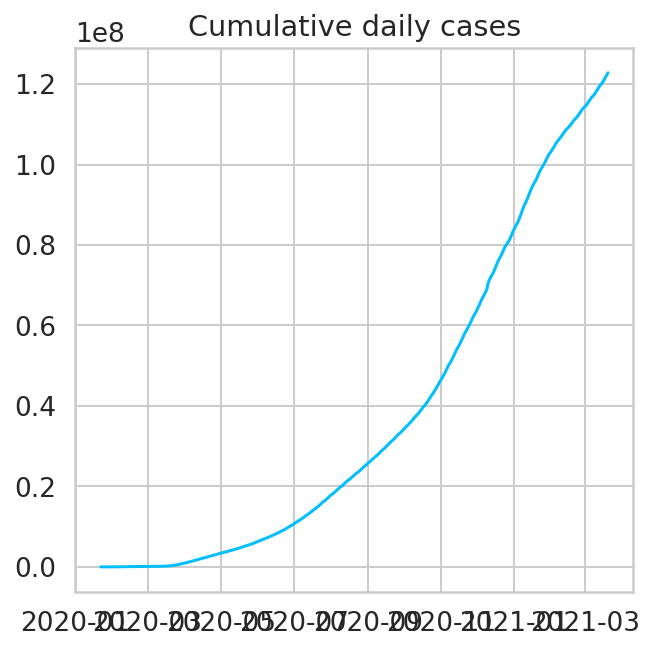

In [59]:
plt.figure(figsize=(5,5))
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

为了提高样本时间序列的平稳性，我们继续取一阶差分。

In [60]:
daily_cases = daily_cases.diff(1).fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23     98
2020-01-24    286
2020-01-25    492
2020-01-26    685
dtype: int64

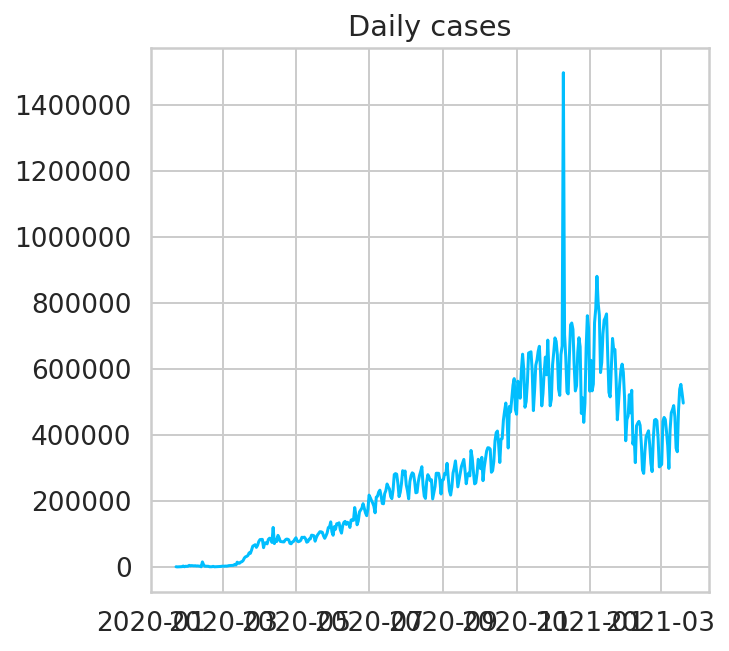

In [61]:
plt.figure(figsize=(5,5))
plt.plot(daily_cases)
plt.title("Daily cases");

## 数据预处理

首先划分数据集为训练集与验证集，我们取最后30天的数据作为测试集，其余作为训练集。

In [62]:
# TEST_DATA_SIZE = 30

# train_data = daily_cases[:-TEST_DATA_SIZE]
# test_data = daily_cases[-TEST_DATA_SIZE:]

# print("The number of the samples in train set is : %i"%train_data.shape[0])
# train_data.shape, test_data.shape

为了提升模型收敛速度与性能，我们使用scikit-learn进行数据归一化。

In [63]:
# scaler = MinMaxScaler()
# train_data = scaler.fit_transform(np.expand_dims(train_data, axis=1)).astype('float32')
# test_data = scaler.transform(np.expand_dims(test_data, axis=1)).astype('float32')

现在开始组建时间序列，可以用前10天的病例数预测当天的病例数。为了让测试集中的所有数据都能参与预测，我们将向测试集补充少量数据，这部分数据只会作为模型的输入。

In [64]:
# SEQ_LEN =10
# train_data_list = []

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length+1):
        x = data[i:i+seq_length-1]
        y = data[i+seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# x_train, y_train = create_sequences(train_data, SEQ_LEN)
# test_data = np.concatenate((train_data[-SEQ_LEN+1:],test_data),axis=0)
# x_test, y_test = create_sequences(test_data, SEQ_LEN)

# print("The shape of x_train is: %s"%str(x_train.shape))
# print("The shape of y_train is: %s"%str(y_train.shape))
# print("The shape of x_test is: %s"%str(x_test.shape))
# print("The shape of y_test is: %s"%str(y_test.shape))

数据集处理完毕，将数据集封装到CovidDataset，以便模型训练、预测时调用。

In [65]:
class CovidDataset(paddle.io.Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        super(CovidDataset, self).__init__()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        return [self.feature[index], self.label[index]]

# train_dataset = CovidDataset(x_train, y_train)
# test_dataset = CovidDataset(x_test, y_test)


## 组网

现在开始组建模型网络，我们采用时间卷积网络TCN作为特征提取器，将提取到的时序信息传送给全连接层获得最终的预测结果。

In [66]:

class Chomp1d(nn.Layer):
    """
    Remove the elements on the right.
    Args:
        chomp_size ([int]): The number of elements removed.
    """

    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]


class TemporalBlock(nn.Layer):
    """
    The TCN block, consists of dilated causal conv, relu and residual block. 
    See the Figure 1(b) in https://arxiv.org/pdf/1803.01271.pdf for more details.
    Args:
        n_inputs ([int]): The number of channels in the input tensor.
        n_outputs ([int]): The number of filters.
        kernel_size ([int]): The filter size.
        stride ([int]): The stride size.
        dilation ([int]): The dilation size.
        padding ([int]): The size of zeros to be padded.
        dropout (float, optional): Probability of dropout the units. Defaults to 0.2.
    """

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 kernel_size,
                 stride,
                 dilation,
                 padding,
                 dropout=0.2):

        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1D(
                n_inputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation))
        # Chomp1d is used to make sure the network is causal.
        # We pad by (k-1)*d on the two sides of the input for convolution, 
        # and then use Chomp1d to remove the (k-1)*d output elements on the right.
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1D(
                n_outputs,
                n_outputs,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
                                 self.dropout1, self.conv2, self.chomp2,
                                 self.relu2, self.dropout2)
        self.downsample = nn.Conv1D(n_inputs, n_outputs,
                                    1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.set_value(
            paddle.tensor.normal(0.0, 0.01, self.conv1.weight.shape))
        self.conv2.weight.set_value(
            paddle.tensor.normal(0.0, 0.01, self.conv2.weight.shape))
        if self.downsample is not None:
            self.downsample.weight.set_value(
                paddle.tensor.normal(0.0, 0.01, self.downsample.weight.shape))

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCNEncoder(nn.Layer):
    """
    A `TCNEncoder` takes as input a sequence of vectors and returns a
    single vector, which is the last one time step in the feature map. 
    The input to this module is of shape `(batch_size, num_tokens, input_size)`, 
    and the output is of shape `(batch_size, num_channels[-1])` with a receptive 
    filed:
    
    .. math::
    
        receptive filed = $2 * \sum_{i=0}^{len(num\_channels)-1}2^i(kernel\_size-1)$.
    
    Temporal Convolutional Networks is a simple convolutional architecture. It outperforms canonical recurrent networks
    such as LSTMs in many tasks. See https://arxiv.org/pdf/1803.01271.pdf for more details.
    Args:
        input_size (int): The number of expected features in the input (the last dimension).
        num_channels (list): The number of channels in different layer. 
        kernel_size (int): The kernel size. Defaults to 2.
        dropout (float): The dropout probability. Defaults to 0.2.
    """

    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCNEncoder, self).__init__()
        self._input_size = input_size
        self._output_dim = num_channels[-1]

        layers = nn.LayerList()
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2**i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride=1,
                    dilation=dilation_size,
                    padding=(kernel_size - 1) * dilation_size,
                    dropout=dropout))

        self.network = nn.Sequential(*layers)
    def get_input_dim(self):
        """
        Returns the dimension of the vector input for each element in the sequence input
        to a `TCNEncoder`. This is not the shape of the input tensor, but the
        last element of that shape.
        """
        return self._input_size

    def get_output_dim(self):
        """
        Returns the dimension of the final vector output by this `TCNEncoder`.  This is not
        the shape of the returned tensor, but the last element of that shape.
        """
        return self._output_dim

    def forward(self, inputs):
        """
        TCNEncoder takes as input a sequence of vectors and returns a
        single vector, which is the last one time step in the feature map. 
        The input to this module is of shape `(batch_size, num_tokens, input_size)`, 
        and the output is of shape `(batch_size, num_channels[-1])` with a receptive 
        filed:
    
        .. math::
        
            receptive filed = $2 * \sum_{i=0}^{len(num\_channels)-1}2^i(kernel\_size-1)$.
        Args:
            inputs (paddle.Tensor): The input tensor with shape `[batch_size, num_tokens, input_size]`.
        Returns:
            output (paddle.Tensor): The output tensor with shape `[batch_size, num_channels[-1]]`.
        """
        inputs_t = inputs.transpose([0, 2, 1])
        output = self.network(inputs_t).transpose([2, 0, 1])[-1]
        return output

<>:109: DeprecationWarning: invalid escape sequence \s
<>:163: DeprecationWarning: invalid escape sequence \s
<>:109: DeprecationWarning: invalid escape sequence \s
<>:163: DeprecationWarning: invalid escape sequence \s
<>:109: DeprecationWarning: invalid escape sequence \s
<>:163: DeprecationWarning: invalid escape sequence \s
<ipython-input-66-d1ce54c76a4b>:109: DeprecationWarning: invalid escape sequence \s
  """
<ipython-input-66-d1ce54c76a4b>:163: DeprecationWarning: invalid escape sequence \s
  """


In [97]:
class TimeSeriesNetwork(nn.Layer):

  def __init__(self, input_size, next_k=1, num_channels=[256]):
    super(TimeSeriesNetwork, self).__init__()

    self.last_num_channel = num_channels[-1]

    self.tcn = TCNEncoder(
      input_size=input_size,
      num_channels=num_channels,
      kernel_size=3, 
      dropout=0.2
    )

    self.linear = nn.Linear(in_features= self.last_num_channel, out_features=next_k)

  def forward(self, x):
    tcn_out = self.tcn(x)
    y_pred = self.linear(tcn_out)
    return y_pred

network = TimeSeriesNetwork(input_size=1)

## 定义优化器、损失函数

在这里我们使用Adam优化器、均方差损失函数，为启动训练做最后的准备。

In [98]:
LR = 1e-2

model = paddle.Model(network)

optimizer = paddle.optimizer.Adam(
        learning_rate=LR, parameters=model.parameters())

loss = paddle.nn.MSELoss(reduction='sum')

model.prepare(optimizer, loss)

## 训练

配置必要的超参数，启动训练。

In [99]:
s1 = [6, 9, 12]
TEST_DATA_SIZe = 30
USE_GPU = False
TRAIN_EPOCH = 100
LOG_FREQ = 20
SAVE_DIR = os.path.join(os.getcwd(),"save_dir")
SAVE_FREQ = 20
preds = []
if USE_GPU:
    paddle.set_device("gpu")
else:
    paddle.set_device("cpu")
for i in range(len(s1)):
    TEST_DATA_SIZE = TEST_DATA_SIZe
    train_data = daily_cases[:-TEST_DATA_SIZE]
    test_data = daily_cases[-TEST_DATA_SIZE:]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(np.expand_dims(train_data, axis=1)).astype('float32')
    test_data = scaler.transform(np.expand_dims(test_data, axis=1)).astype('float32')

    x_train, y_train = create_sequences(train_data, s1[i])
    test_data = np.concatenate((train_data[-s1[i]+1:],test_data),axis=0)
    x_test, y_test = create_sequences(test_data, s1[i])

    print("The shape of x_train is: %s"%str(x_train.shape))
    print("The shape of y_train is: %s"%str(y_train.shape))
    print("The shape of x_test is: %s"%str(x_test.shape))
    print("The shape of y_test is: %s"%str(y_test.shape))

    train_dataset = CovidDataset(x_train, y_train)
    test_dataset = CovidDataset(x_test, y_test)
    
    model.fit(train_dataset, 
        batch_size=64,
        drop_last=True,
        epochs=TRAIN_EPOCH,
        log_freq=LOG_FREQ,
        save_dir=SAVE_DIR,
        save_freq=SAVE_FREQ,
        verbose=1
        )
    preds.append(model.predict(
        test_data=test_dataset
        ))
    # print(scaler.inverse_transform(
    #     np.expand_dims(np.array(preds).flatten(), axis=0)
    #     ).flatten())

The shape of x_train is: (389, 5, 1)
The shape of y_train is: (389, 1)
The shape of x_test is: (30, 5, 1)
The shape of y_test is: (30, 1)
The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/100
step 6/6 [==============================] - loss: 35.0127 - 45ms/step
save checkpoint at /home/aistudio/save_dir/0
Epoch 2/100
step 6/6 [==============================] - loss: 4.4932 - 45ms/step
Epoch 3/100
step 6/6 [==============================] - loss: 1.4591 - 44ms/step
Epoch 4/100
step 6/6 [==============================] - loss: 2.6139 - 44ms/step
Epoch 5/100
step 6/6 [==============================] - loss: 0.9748 - 47ms/step
Epoch 6/100
step 6/6 [==============================] - loss: 0.4790 - 50ms/step
Epoch 7/100
step 6/6 [==============================] - loss: 1.4330 - 44ms/step
Epoch 8/100
step 6/6 [==============================] - loss: 0.8596 - 43ms/step
Epoch 9/100
step 6/6 [==============================] - los

In [102]:
list_result = np.zeros((TEST_DATA_SIZe))
rate = [0.4, 0.5, 0.1]
for i in range(len(s1)):
    list_result += (scaler.inverse_transform(
        np.expand_dims(np.array(preds[i]).flatten(), axis=0)
        ).flatten())*rate[i]
final_result = list_result
print(list_result)

[391288.71484375 398433.23046875 367398.08984375 317194.14453125
 302195.78515625 415322.203125   472239.109375   431455.96484375
 425762.44921875 385960.17578125 309054.26171875 326485.40625
 349790.86328125 457759.36328125 458292.08984375 427382.63671875
 400929.1484375  370472.3515625  313741.55859375 436507.890625
 505596.97265625 460465.77734375 466575.515625   446833.72265625
 361653.1796875  360934.6953125  511616.43359375 571232.2734375
 521789.57421875 501037.22265625]


<class 'pandas.core.series.Series'>
424 394
30 30
Tensor(shape=[1], dtype=float64, place=CPUPlace, stop_gradient=True,
       [48922.43281224])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


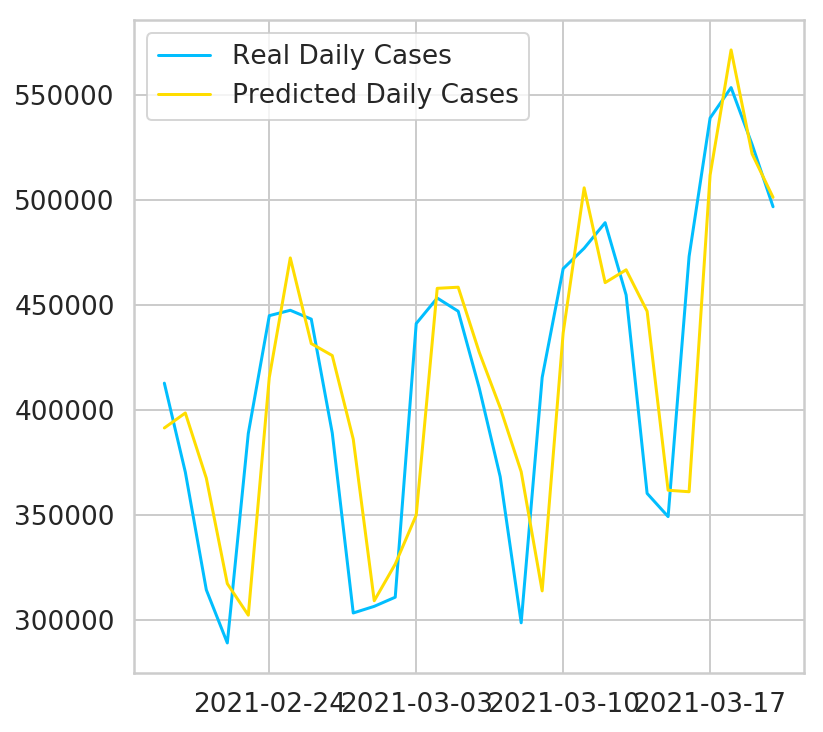

In [103]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten(), axis=0)
).flatten()

print (type(daily_cases))
# print(daily_cases[1:3])
print (len(daily_cases), len(train_data))
daily_cases.index[:len(train_data)]
mse_loss = paddle.nn.MSELoss(reduction='mean')
print(len(true_cases), len(final_result))
print(paddle.sqrt(mse_loss(paddle.to_tensor(true_cases).astype('float'), paddle.to_tensor(final_result).astype('float'))))
# print(true_cases, final_result)

plt.figure(figsize=(6,6))
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  final_result, 
  label='Predicted Daily Cases'
)

plt.legend();


In [82]:
import numpy as np
predicted_cases = final_result
true_cases, predicted_cases
## 利用范数实现
## MSE--相当于y-y_hat的二阶范数的平方/n
MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)
## RMSE--相当于y-y_hat的二阶范数/根号n
RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5
## MAE--相当于y-y_hat的一阶范数/n
MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

[MAE,RMSE,MAE]

[39448.723307291664, 50904.15885838802, 39448.723307291664]

In [73]:
# USE_GPU = False
# TRAIN_EPOCH = 100
# LOG_FREQ = 20
# SAVE_DIR = os.path.join(os.getcwd(),"save_dir")
# SAVE_FREQ = 20

# if USE_GPU:
#     paddle.set_device("gpu")
# else:
#     paddle.set_device("cpu")

# model.fit(train_dataset, 
#     batch_size=32,
#     drop_last=True,
#     epochs=TRAIN_EPOCH,
#     log_freq=LOG_FREQ,
#     save_dir=SAVE_DIR,
#     save_freq=SAVE_FREQ,
#     verbose=1
#     )

## 预测

使用训练完毕的模型，对测试集中的日期对应的病例数进行预测。


In [74]:
# preds = model.predict(
#         test_data=test_dataset
#         )

## 数据后处理

将归一化的数据转换为原始数据，画出真实值对应的曲线和预测值对应的曲线。

In [75]:
# true_cases = scaler.inverse_transform(
#     np.expand_dims(y_test.flatten(), axis=0)
# ).flatten()

# predicted_cases = scaler.inverse_transform(
#   np.expand_dims(np.array(preds).flatten(), axis=0)
# ).flatten()
# true_cases.shape, predicted_cases.shape

In [76]:
# print (type(daily_cases))
# daily_cases[1:3]
# print (len(daily_cases), len(train_data))
# daily_cases.index[:len(train_data)]
# mse_loss = paddle.nn.MSELoss(reduction='mean')
# print(paddle.sqrt(mse_loss(paddle.to_tensor(true_cases), paddle.to_tensor(predicted_cases))))
# true_cases, predicted_cases

In [77]:
# # plt.plot(
# #   daily_cases.index[:len(train_data)], 
# #   scaler.inverse_transform(train_data).flatten(),
# #   label='Historical Daily Cases'
# # )
# plt.figure(figsize=(6,6))
# plt.plot(
#   daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
#   true_cases,
#   label='Real Daily Cases'
# )

# plt.plot(
#   daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
#   predicted_cases, 
#   label='Predicted Daily Cases'
# )

# plt.legend();

## 进一步优化模型

从上图中，我们可以看到模型大体上预测到了病例数涨幅的升降情况，在具体数值上则出现了一些误差。读者可以发挥创造力，进一步提升模型的精度与功能，例如：

1. 预测未来n天

我们现在是用已知的9天病例数，预测第10天的病例数，我们可以将第10天的预测结果与前8天的真实病例数拼接，预测第11天的病例数，以此类推即可预测未来n天的病例数。

2. 优化模型网络

本文采用的是TCN模型，如果不考虑模型的速度性能，可以尝试LSTM, GRU, transformer等模型，进一步提升模型的拟合能力。

3. 优化模型超参数

本文没有对超参设置进行探索，读者可以探索设置更加合理的学习率，训练轮次，TCN通道数等。

4. 考虑更多的数据特征

本文只考虑了病例的日期，没有考虑政策、疫苗研制情况等具体环境的影响，读者可以搜集更多的新闻资料，加入更多的数据特征。

# PaddleNLP 更多项目
 - [seq2vec是什么? 瞧瞧怎么用它做情感分析](https://aistudio.baidu.com/aistudio/projectdetail/1283423)
 - [如何通过预训练模型Fine-tune下游任务](https://aistudio.baidu.com/aistudio/projectdetail/1294333)
 - [使用BiGRU-CRF模型完成快递单信息抽取](https://aistudio.baidu.com/aistudio/projectdetail/1317771)
 - [使用预训练模型ERNIE优化快递单信息抽取](https://aistudio.baidu.com/aistudio/projectdetail/1329361)
 - [使用Seq2Seq模型完成自动对联](https://aistudio.baidu.com/aistudio/projectdetail/1321118)
 - [使用预训练模型ERNIE-GEN实现智能写诗](https://aistudio.baidu.com/aistudio/projectdetail/1339888)
 - [使用预训练模型完成阅读理解](https://aistudio.baidu.com/aistudio/projectdetail/1339612)
 - [自定义数据集实现文本多分类任务](https://aistudio.baidu.com/aistudio/projectdetail/1468469)